Loading MNIST...
Subset shape: (22164, 784), Classes: [3 5 7 9]
Test shape: (5541, 784), Classes: [3 5 7 9]
Train shape: (22164, 784), Classes: [3 5 7 9]
GLVQ Accuracy: 0.8958671719906154

Classification Report:
               precision    recall  f1-score   support

           3       0.87      0.95      0.91      1444
           5       0.96      0.84      0.90      1232
           7       0.86      0.94      0.90      1463
           9       0.92      0.84      0.88      1402

    accuracy                           0.90      5541
   macro avg       0.90      0.89      0.90      5541
weighted avg       0.90      0.90      0.90      5541



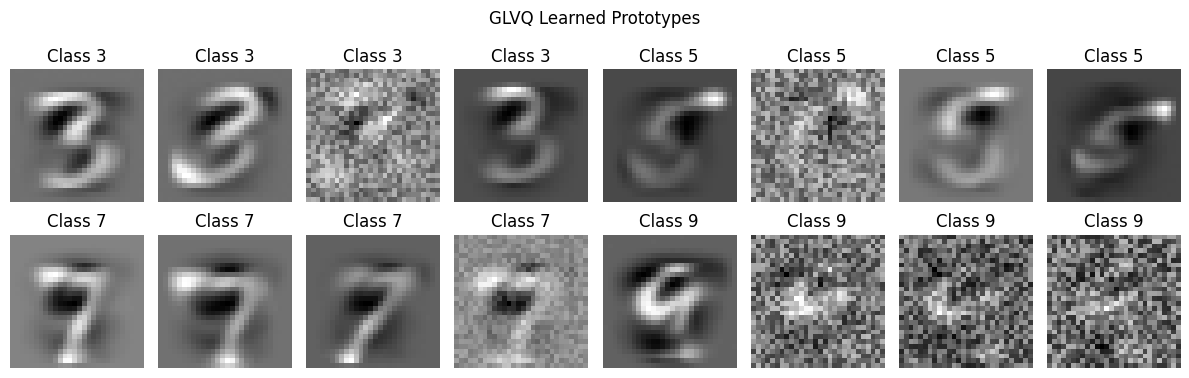


 Counterfactual found for sample index 0
   Original prediction     : 9
   Target prediction (goal): 3
   Counterfactual prediction: 3
   Success? Yes
  Norm of change (||Δ||): 34.9502
 Index 1: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)
 Index 2: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)
 Index 3: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)
 Index 4: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)
 Index 5: Counterfactual not found (No counterfactual found - Consider changing parameters 'regularization', 'features_whitelist', 'optimizer' and try again)
 Index 6: Counterfactual

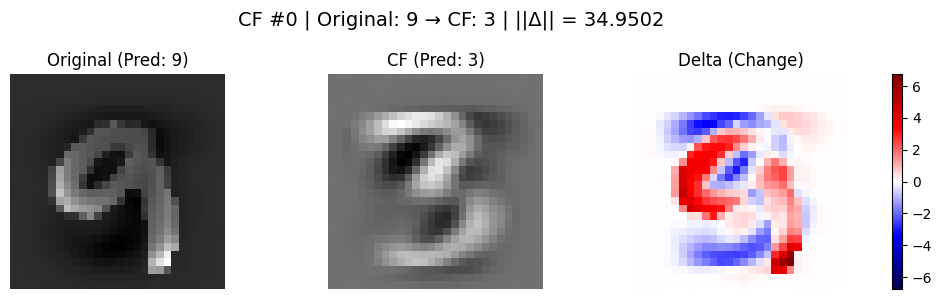

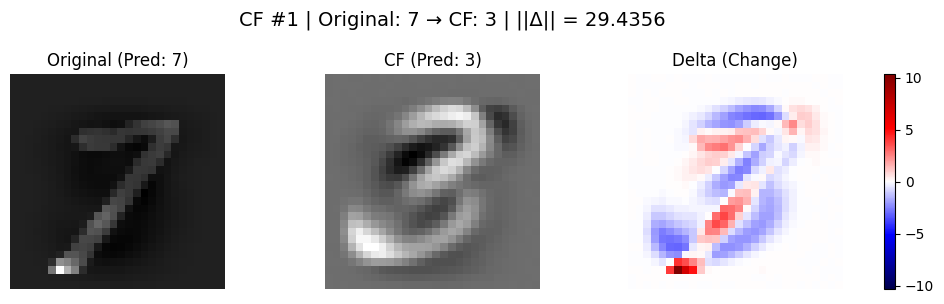

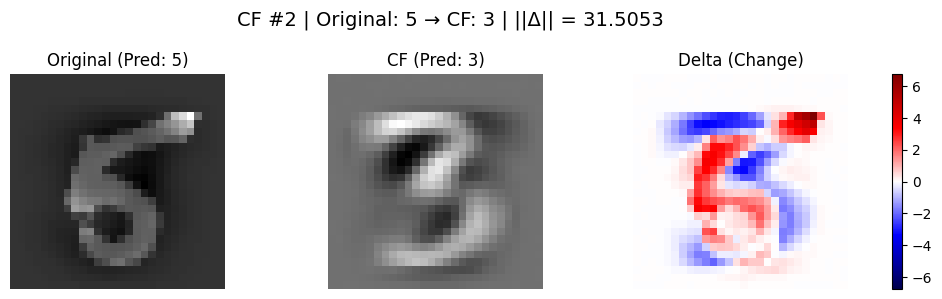

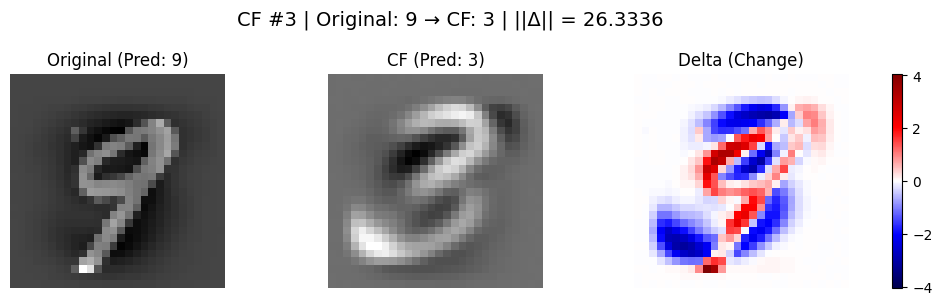

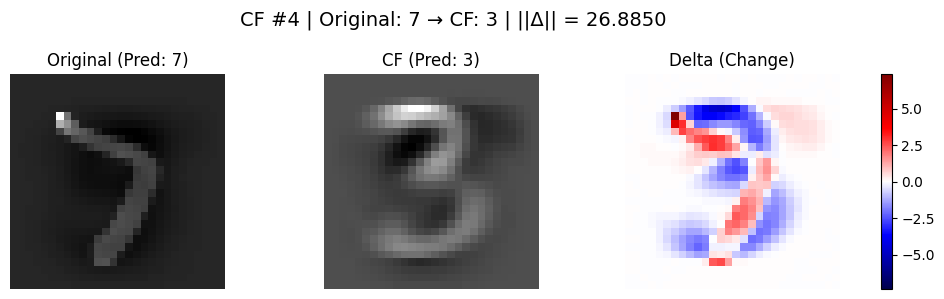

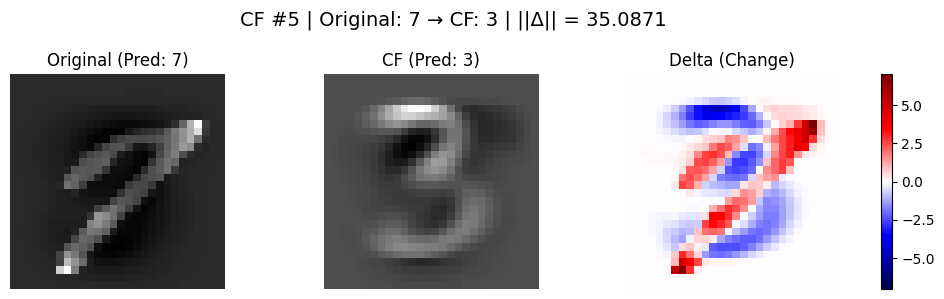

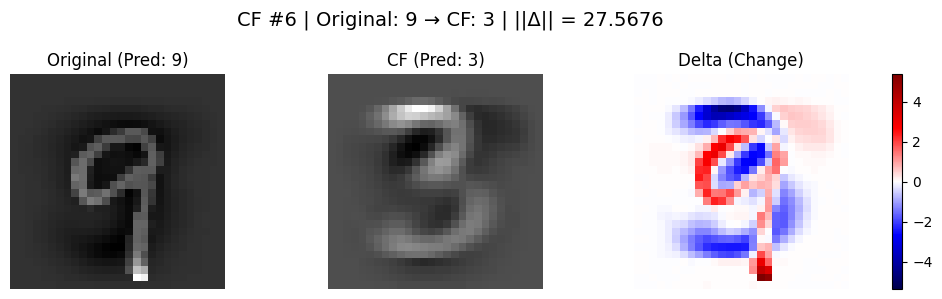

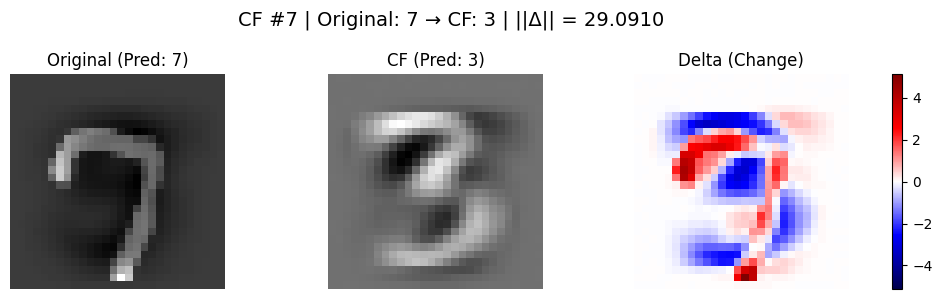

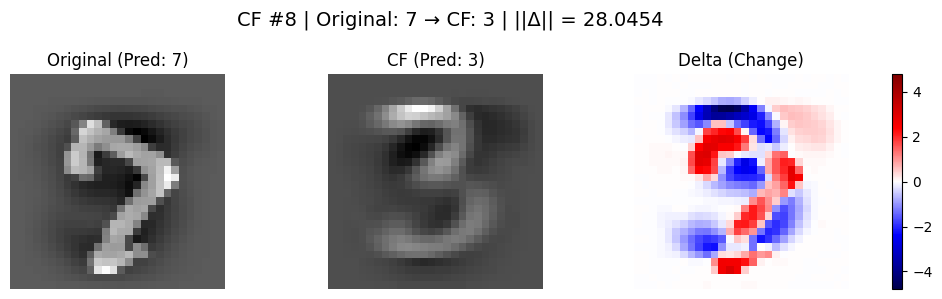

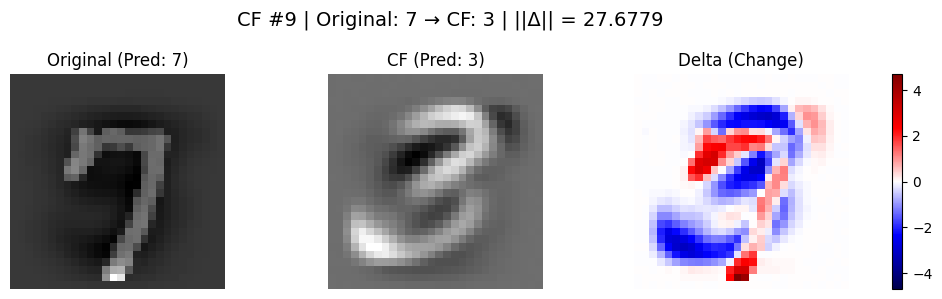

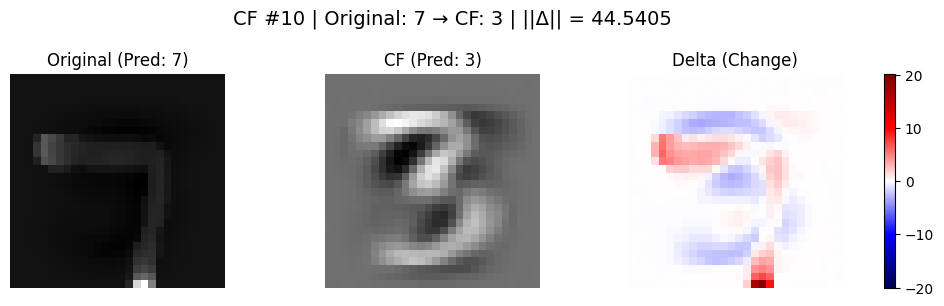

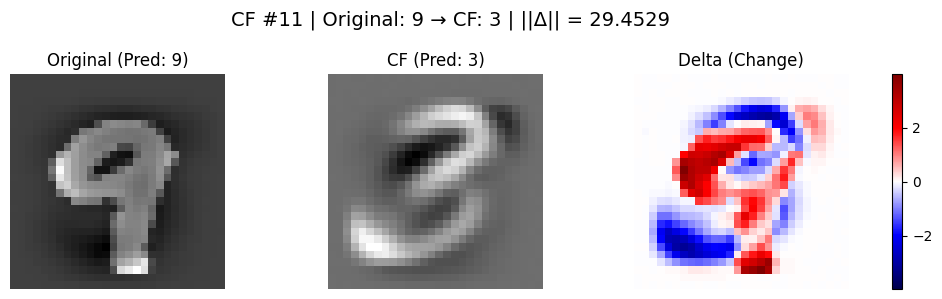

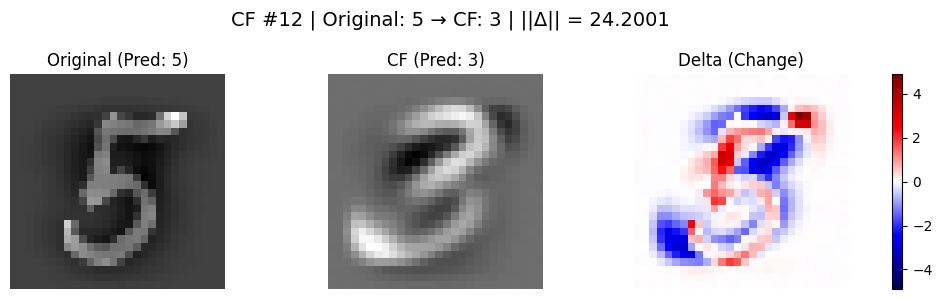

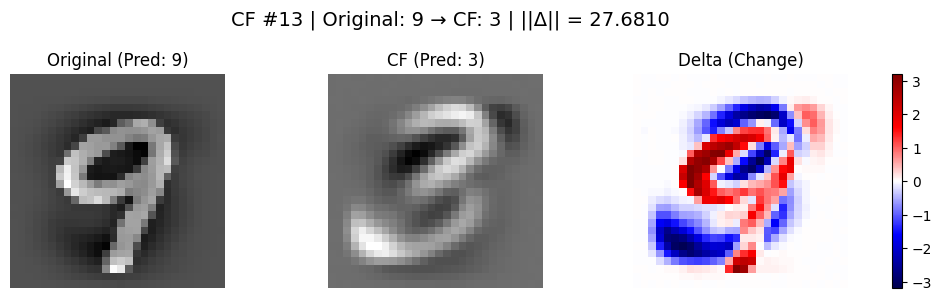

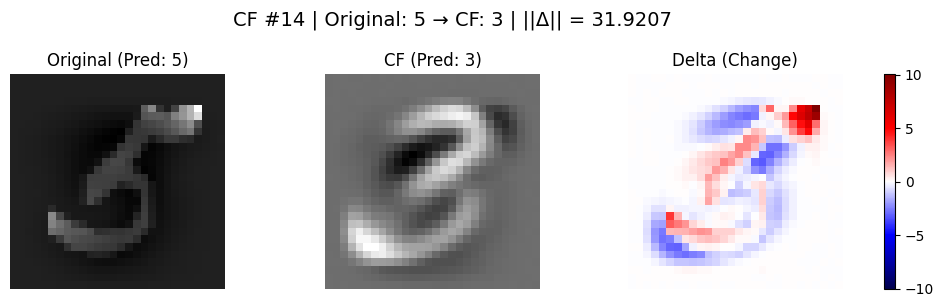

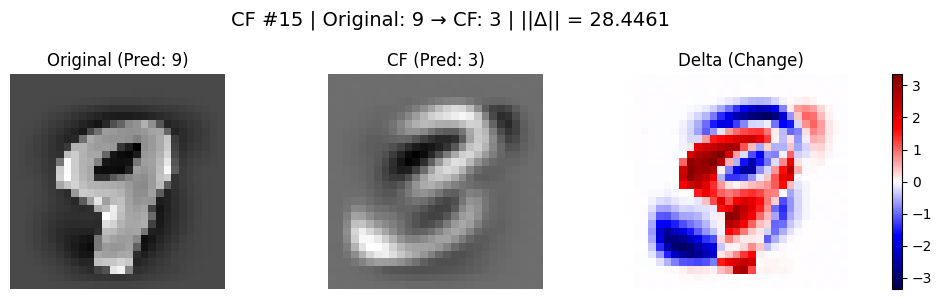

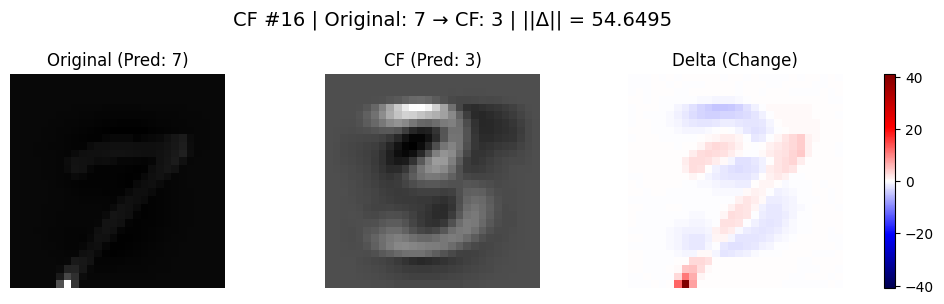

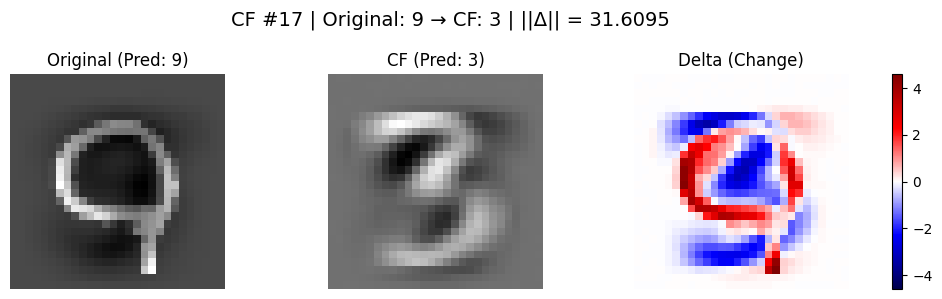

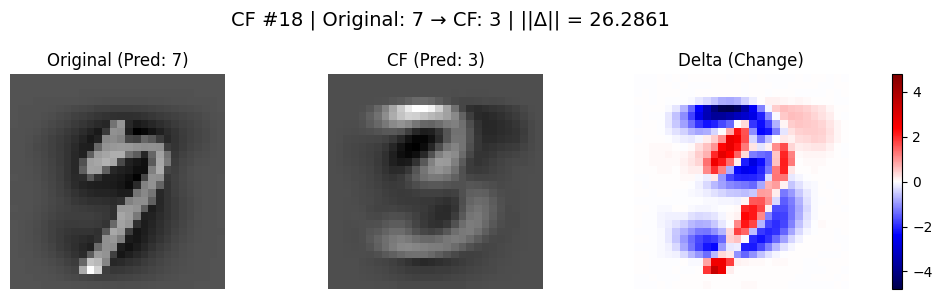

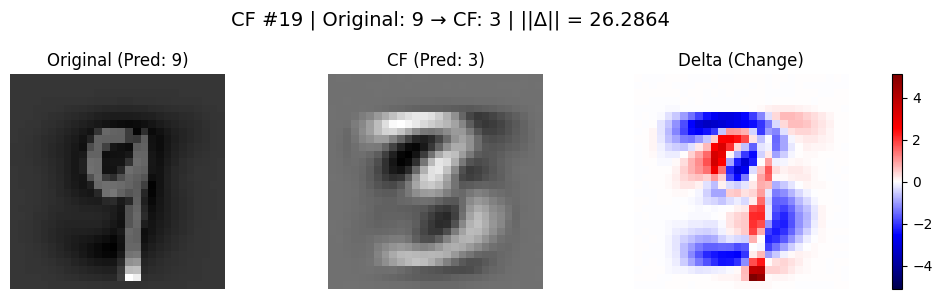

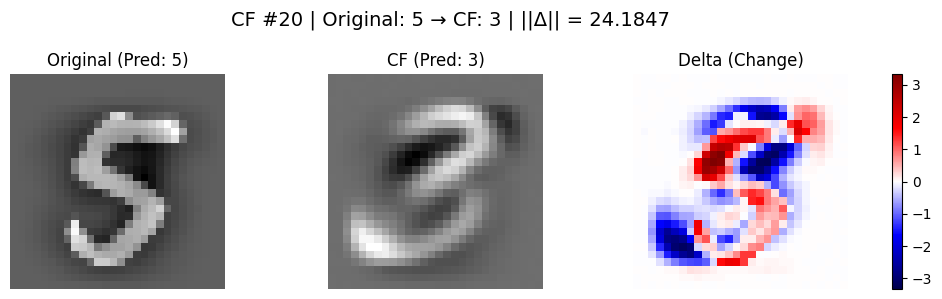

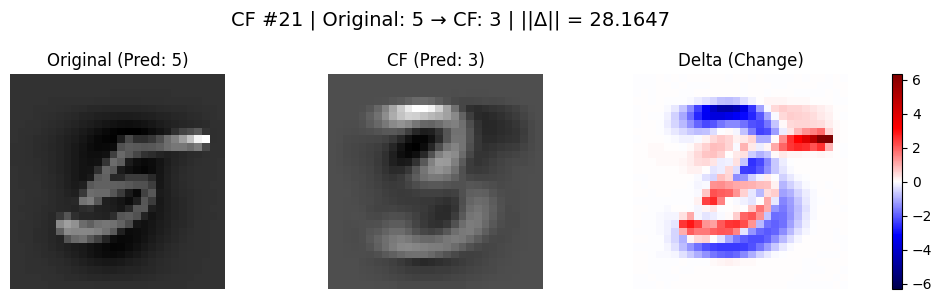

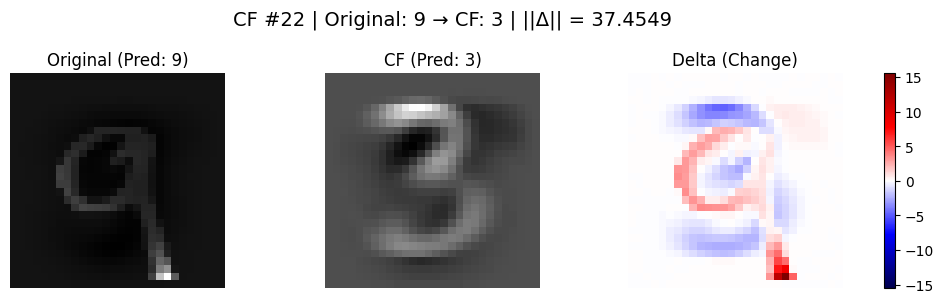

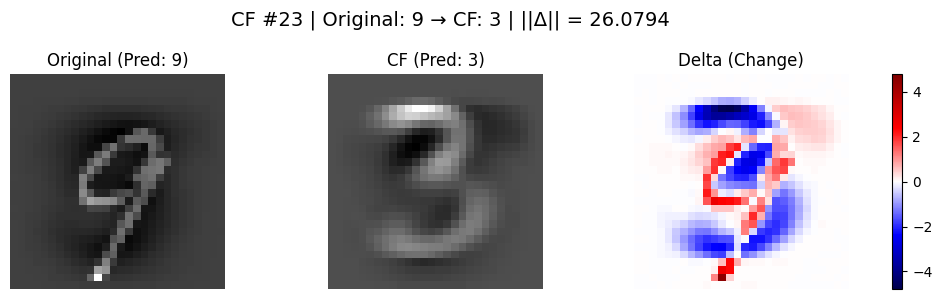

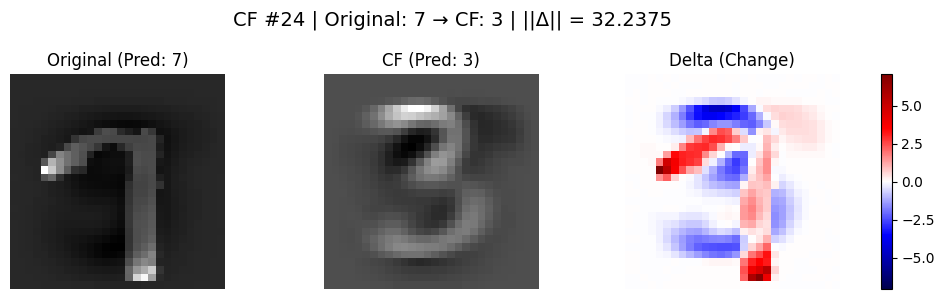

In [1]:
# Import Libraries
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


from ceml.sklearn.lvq import LvqCounterfactual, lvq_generate_counterfactual
from sklearn.metrics import accuracy_score, classification_report

from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn_lvq import GlvqModel
from sklearn.metrics import accuracy_score

import jax.numpy as npx
from ceml.backend.jax.costfunctions import CostFunctionDifferentiableJax

# Load full MNIST dataset
print("Loading MNIST...")
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, as_frame=False, parser='auto')

# Convert labels to integers
y = y.astype(int)

# Custom implementation of the l2-regularization. Note that this regularization is differentiable
class MyRegularization(CostFunctionDifferentiableJax):
    def __init__(self, x_orig):
        self.x_orig = x_orig

        super(MyRegularization, self).__init__()
    
    def score_impl(self, x):
        return npx.sum(npx.square(x - self.x_orig)) 

# 2. Select only digits 3, 5, 7, 9
target_digits = [3, 5, 7, 9]
subset_indices = np.isin(y, target_digits)
X_subset, y_subset = X[subset_indices], y[subset_indices]



# 4. Normalize pixel values to [0, 1]
X_subset = X_subset.astype(np.float32) / 255.0

# 5. Standardize (zero mean, unit variance)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

# 6. Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_subset, test_size=0.2, random_state=42
)

print(f"Subset shape: {X_train.shape}, Classes: {np.unique(y_train)}")
print(f"Test shape: {X_test.shape}, Classes: {np.unique(y_test)}")
print(f"Train shape: {X_train.shape}, Classes: {np.unique(y_train)}")


# 5. Create and Train GLVQ Model
glvq = GlvqModel(prototypes_per_class=4, max_iter=1000, random_state=42)
# Save the original _optimize method
original_optimize = glvq._optimize

# Create a patched version that flattens the prototypes
def patched_optimize(x, y, random_state):
    # Save the original shape of the prototypes
    original_shape = glvq.w_.shape
    # Flatten the prototypes for optimization
    glvq.w_ = glvq.w_.ravel()
    # Call the original optimization method (which updates model.w_ in place)
    original_optimize(x, y, random_state)
    # Reshape the optimized prototypes back to their original shape
    glvq.w_ = glvq.w_.reshape(original_shape)


glvq._optimize = patched_optimize
glvq.fit(X_train, y_train)

# 6. Evaluate
y_pred = glvq.predict(X_test)
print("GLVQ Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# 7. Visualize learned prototypes
prototypes = glvq.w_.reshape(-1, 28, 28)
labels = glvq.c_w_

plt.figure(figsize=(12, 4))
for i in range(len(prototypes)):
    plt.subplot(2, len(prototypes) // 2, i + 1)
    plt.imshow(prototypes[i], cmap='gray')
    plt.title(f"Class {labels[i]}")
    plt.axis('off')
plt.suptitle("GLVQ Learned Prototypes")
plt.tight_layout()
plt.show()




cf_data = []
sample_indices = range(100)  # First 100 samples

for idx in sample_indices:
    x_sample = X_test[idx]
    y_orig = glvq.predict([x_sample])[0]
      # Create custom regularization function
    regularization = MyRegularization(x_sample)

    # Choose a different target class
    all_classes = list(set(y_train))
    possible_targets = [c for c in all_classes if c != y_orig]
    y_target = random.choice(possible_targets)

    try:
        cf = lvq_generate_counterfactual(
            glvq,
            x_sample,
            y_target,
            features_whitelist=None,
            dist='l1',
            regularization=regularization,
            C=[0.1, 1.0, 10.0, 100.0, 1000.0],
            optimizer='auto',
            optimizer_args={"solver": "SLSQP",},
        )

        x_cf = np.array(cf['x_cf'])
        delta = np.array(cf['delta'])
        x_original = x_cf - delta
        y_cf = cf['y_cf']
        delta_norm = np.linalg.norm(delta)

        # Store result
        cf_data.append((x_sample, x_cf, delta, y_orig, y_cf))

        # Print result
        print(f"\n Counterfactual found for sample index {idx}")
        print(f"   Original prediction     : {y_orig}")
        print(f"   Target prediction (goal): {y_target}")
        print(f"   Counterfactual prediction: {y_cf}")
        print(f"   Success? { 'Yes' if y_cf == y_target else 'No'}")
        print(f"  Norm of change (||Δ||): {delta_norm:.4f}")

    except Exception as e:
        print(f" Index {idx}: Counterfactual not found ({e})")





# Prepare data for export
cf_export = []

for idx, (x_sample, x_cf, delta, y_orig, y_cf) in enumerate(cf_data):
    row = {
        'Index': idx,
        'Original Prediction': y_orig,
        'Counterfactual Prediction': y_cf,
        'Delta Norm': np.linalg.norm(delta)
    }
    cf_export.append(row)


# 8. Visualize Counterfactuals


# Loop through all counterfactuals
for i, (x_orig, x_cf, delta, y_orig, y_cf) in enumerate(cf_data):
    img_orig = x_orig.reshape(28, 28)
    img_cf = x_cf.reshape(28, 28)
    img_delta = delta.reshape(28, 28)
    max_val = np.abs(img_delta).max()
    delta_norm = np.linalg.norm(delta)

    plt.figure(figsize=(10, 3))

    plt.subplot(1, 3, 1)
    plt.imshow(img_orig, cmap='gray')
    plt.title(f"Original (Pred: {y_orig})")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(img_cf, cmap='gray')
    plt.title(f"CF (Pred: {y_cf})")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(img_delta, cmap='seismic', vmin=-max_val, vmax=max_val)
    plt.title("Delta (Change)")
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

    # Include L2 norm in the overall title
    plt.suptitle(f"CF #{i} | Original: {y_orig} → CF: {y_cf} | ||Δ|| = {delta_norm:.4f}", fontsize=14)
    plt.tight_layout()
    plt.axis('equal')

    plt.show()

